In [11]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

df = pd.read_csv("diabetes.csv", index_col=False)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [12]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Text(0.5, 1.0, 'Outcome')

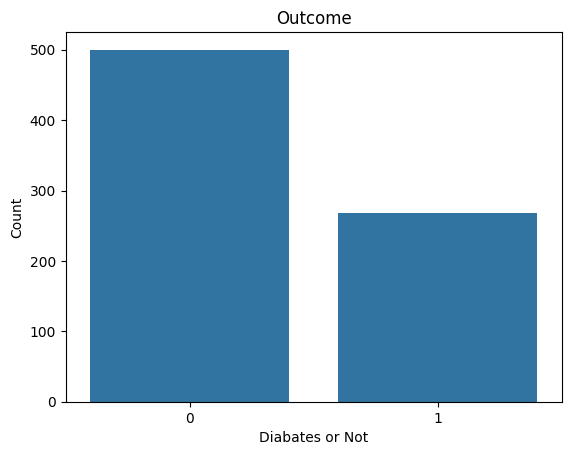

In [13]:
sns.countplot(data = df, x="Outcome")
plt.xlabel("Diabates or Not")
plt.ylabel("Count")
plt.title("Outcome")

In [15]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [16]:
df = df.dropna()
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [18]:
X=df.drop('Outcome',axis=1)
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [19]:
y=df['Outcome']
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [20]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.1, 
                                                    shuffle = True, 
                                                    random_state = 21)

In [21]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [22]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 5)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 5)
print(X_test.shape, y_test.shape) 

(687, 5, 8) (687,)
(73, 5, 8) (73,)


In [23]:
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [25]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from keras.layers import Dense, Flatten, Dropout

In [28]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_onehot.shape[1]

In [29]:
input_layer = Input(shape=(n_timesteps,n_features))

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer) 
flat = Flatten()(conv1)
dens = Dense(64, activation = "relu")(flat)
outputs = Dense(2, activation = "sigmoid")(dens)

model = keras.Model(input_layer, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 8)]            0         
                                                                 
 conv1d (Conv1D)             (None, 3, 64)             1600      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 64)                12352     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 14082 (55.01 KB)
Trainable params: 14082 (55.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
train_epochs = 30
history = model.fit(X_train, y_train_onehot, epochs=train_epochs, verbose=True,  validation_split = 0.1)

Epoch 1/30


20/20 [==============================] - 2s 24ms/step - loss: 3.9684 - accuracy: 0.5696 - val_loss: 2.8026 - val_accuracy: 0.5797
Epoch 2/30
20/20 [==============================] - 0s 7ms/step - loss: 1.5336 - accuracy: 0.6618 - val_loss: 1.5723 - val_accuracy: 0.6522
Epoch 3/30
20/20 [==============================] - 0s 7ms/step - loss: 1.0961 - accuracy: 0.6909 - val_loss: 1.3376 - val_accuracy: 0.6377
Epoch 4/30
20/20 [==============================] - 0s 6ms/step - loss: 0.9690 - accuracy: 0.7039 - val_loss: 1.4146 - val_accuracy: 0.7246
Epoch 5/30
20/20 [==============================] - 0s 7ms/step - loss: 0.8163 - accuracy: 0.7265 - val_loss: 1.4502 - val_accuracy: 0.6667
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 0.6772 - accuracy: 0.7686 - val_loss: 1.3014 - val_accuracy: 0.6957
Epoch 7/30
20/20 [==============================] - 0s 7ms/step - loss: 0.6674 - accuracy: 0.7589 - val_loss: 1.4577 - val_accuracy: 0.7101
Epoch 8/30
20/20 

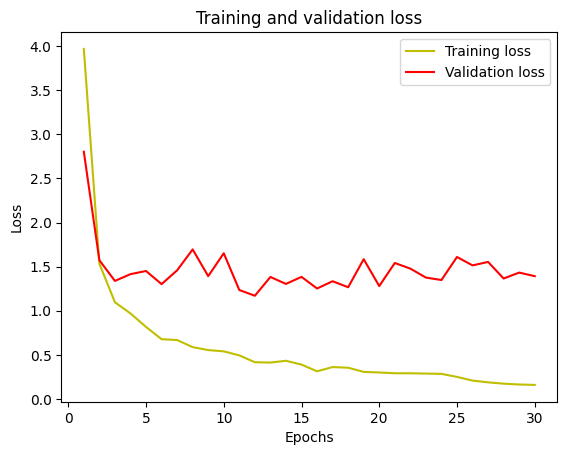

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

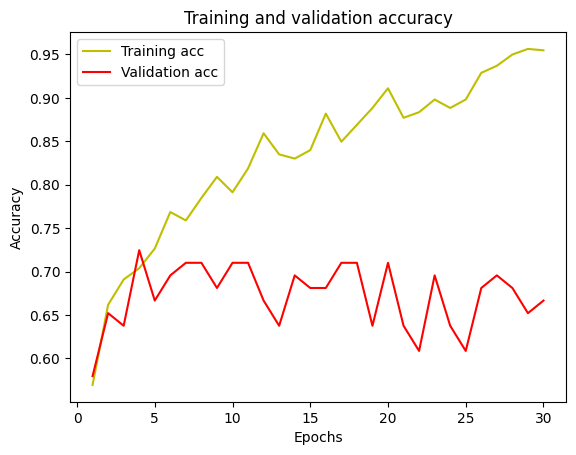

In [32]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:

#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix


y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test_onehot,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

3/3 [==============================] - 0s 4ms/step


In [34]:

#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.65      0.89      0.75        45
           1       0.55      0.21      0.31        28

    accuracy                           0.63        73
   macro avg       0.60      0.55      0.53        73
weighted avg       0.61      0.63      0.58        73

[[40  5]
 [22  6]]
